In [1]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Congratulations!  It's a clustering solution.  But how can you tell if your arrangement of bouncing baby blobs will amount to anything in the real world?  And if you have more than one promising clustering solution, which one should you take home with you?


## Consistency

When it comes to choosing the number of clusters and the clustering algorithm, one critical component is consistency across sub-samples or folds.  Clusters are useful if the same kind of data points are grouped together each time you run your clustering algorithm on different subsets of the same data.  However, unlike the cross-validation and test/re-test methods you are familiar with from supervised learning, there's no formal metric for assessing how "similar" clusters are between different sets of data.  

We are going to compare two, three, and four-cluster solutions for the [UC Irvine Heart Disease data](http://archive.ics.uci.edu/ml/datasets/Heart+Disease) that you may recall from before. We'll be using $k$-means and dividing the data into four samples of equal size. Our goal will be to see which number of clusters gives the most consistent results across the four samples.

If we only had two features in the data, it would be easy to see which cluster solution was doing the best by simply graphing the results for all the samples and coloring the clusters, as we have done previously.   However, in real life it is unlikely that you will only do clustering on two-feature datasets. While PCA can be used to reduce dimensionality down to two features, there is an inevitable loss of information. Here, we will use all the features in the UC Irvine heart disease data to create our clusters.

However, to compare our solutions, we plot the cluster assignments against two features created by PCA.  This is just for visualization purposes – our solution is based on all the features in the data.

In [2]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

data_path = ("https://tf-assets-prod.s3.amazonaws.com/"
             "tf-curric/data-science/cleveland-data.csv")
df = pd.read_csv(data_path)

# Make sure the number of rows divides evenly into four samples.
rows = df.shape[0] - df.shape[0] % 4
df = df.iloc[:rows, :]

# Break into a set of features and a variable for the known outcome.
X = df.iloc[:, :13]
y = df.iloc[:, 13]

# Replace some random string values.
X = X.replace(to_replace='?', value=0)

# Binarize y so that 1 means heart disease diagnosis and 0 means no diagnosis.
y = np.where(y > 0, 0, 1)

# Normalize
X_norm = normalize(X)

# Data frame to store features and predicted cluster memberships.
ypred = pd.DataFrame()

# Create the two-feature PCA for graphing purposes.
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_norm)

# Split the data into four equally-sized samples. First we break it in half:
X_half1, X_half2, X_pcahalf1, X_pcahalf2 = train_test_split(
    X_norm,
    X_pca,
    test_size=0.5,
    random_state=42)

# Then we halve the halves.
X1, X2, X_pca1, X_pca2 = train_test_split(
    X_half1,
    X_pcahalf1,
    test_size=0.5,
    random_state=42)
X3, X4, X_pca3, X_pca4 = train_test_split(
    X_half2,
    X_pcahalf2,
    test_size=0.5,
    random_state=42)

# Pass a list of tuples and a counter that increments each time we go
# through the loop. The tuples are the data to be used by k-means,
# and the PCA-derived features for graphing. We use k-means to fit a
# model to the data, then store the predicted values and the two-feature
# PCA solution in the data frame.
for counter, data in enumerate([
    (X1, X_pca1),
    (X2, X_pca2),
    (X3, X_pca3),
    (X4, X_pca4)]):
    
    # Put the features into ypred.
    ypred['pca_f1' + '_sample' + str(counter)] = data[1][:, 0]
    ypred['pca_f2' + '_sample' + str(counter)] = data[1][:, 1]
    
    # Generate cluster predictions and store them for clusters 2 to 4.
    for nclust in range(2, 5):
        pred = KMeans(n_clusters=nclust, random_state=42).fit_predict(data[0])
        ypred['clust' + str(nclust) + '_sample' + str(counter)] = pred

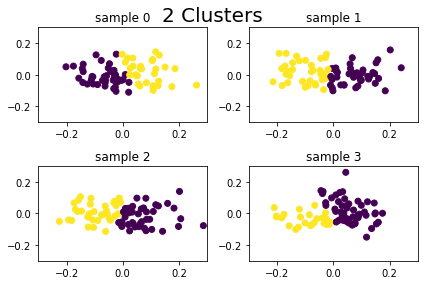

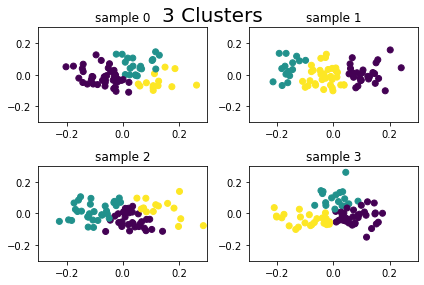

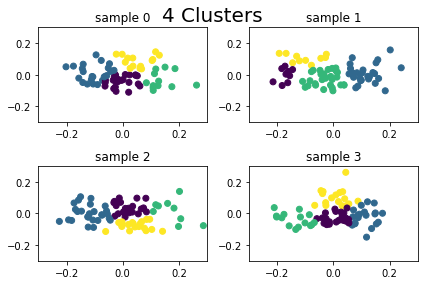

In [3]:
# For each  number of clusters, plot the clusters using the
# pca features for each sample.
for cluster in range(2, 5):
    
    # Make a grid of subplots.
    f, axarr = plt.subplots(2, 2)
    
    # Make a plot for each sample.
    for i in range(4):
        
        # PCA-created features.
        x_sub = ypred['pca_f1_sample{}'.format(i)]
        y_sub = ypred['pca_f2_sample{}'.format(i)]
        
        # Cluster assignments.
        c = ypred['clust{}_sample{}'.format(cluster, i)]
        
        # Assign the subplot to its place on the grid.
        rows = int(np.floor(i / 2))
        cols = i % 2
        axarr[rows, cols].scatter(x_sub, y_sub, c=c)
        axarr[rows, cols].set_title('sample {}'.format(i))
        axarr[rows, cols].set_xlim([-.3, .3])
        axarr[rows, cols].set_ylim([-.3, .3])
    
    # Space out the plots so that the headings don't overlap axis values.
    plt.suptitle('{} Clusters'.format(cluster), fontsize=20)
    plt.tight_layout()
    plt.show()
    print('\n')

Ignoring the specific colors assigned to each cluster, it appears that the two-cluster solution yields the most consistent results in terms of cluster center and cluster shape. Don't forget, however, that we are evaluating this based on two features from PCA rather than the n-dimensional data actually used by $k$-means, so the information value of these plots depends on how much information is retained by the PCA.

## Cluster-level descriptive statistics

Another way of evaluating the consistency of clusters is to compute descriptive statistics for the features for each cluster. Clusters made from different random samples of the dataset should have relatively similar scores and variances for each feature.

## When you have existing labels: Contingency tables, RI, and ARI

If you have a "ground truth" – some existing data point group memberships that you can use to check your clusters against – then you can choose the cluster solution that most closely replicates the group memberships you already know. [There are a lot of methods for this](http://scikit-learn.org/stable/modules/clustering.html#clustering-performance-evaluation). We will review two, the very basic contingency table, and somewhat more complex the Adjusted Rand Index, or "ARI".

### Contingency tables
Here is an example of a _contingency table_ comparing the cluster memberships for the ground truth (GT) and the new cluster solution (NS) for our fairly lousy $k$-means analysis of the heart disease data:

In [6]:
# Get predicted clusters.
full_pred = KMeans(n_clusters=2, random_state=42).fit_predict(X_norm)

pd.crosstab(y, full_pred) 

NameError: name 'X_norm' is not defined

This is informative.  We could go further and convert it to a ratio of "correctly assigned" datapoints to total datapoints, to get a one-number solution we could use to compare across algorithms. However, this basic contingency table solution fails to capture one of the most important things about clustering – that it not only tells us about cluster memberships of individual datapoints, but also about the relationships between datapoint pairs.  To do that, we need the:


### Rand Index

The _Rand Index_ compares how pairs of datapoints relate in the ground truth and in the new solution.  There are four possible types of pair relationships:

 1. Members of the same cluster in the ground truth, and members of the same cluster in the new solution.  
 2. Members of the same cluster in the ground truth, and members of different clusters in the new solution.  
 3. Members of different clusters in the ground truth, and members of the same cluster in the new solution.  
 4. Members of different clusters in the ground truth, and members of different clusters in the new solution.  

The Rand Index, or $RI$, is the ratio of the number of pairs where the ground truth and the new solution agree, over the total number of pairs.

$$RI=\dfrac{a+c}{a+b+c+d}$$

Scores range from 0 to 1, where 1 indicates perfect agreement between the ground truth and the new solution.

Let's calculate the $RI$ by hand:


In [5]:
# Note: the itertools module is tons of fun and very useful.
import itertools

# Create a list of pairs, where each pair is the ground truth group
# and the assigned cluster.
c = list(itertools.product(y, full_pred))

# Count how often each type of pair (a, b, c, or d) appears.
RIcounts = [[x, c.count(x)] for x in set(c)]
print(RIcounts)

# Create the same counts but without the label, for easier math below.
RIcounts_nolabel = [c.count(x) for x in set(c)]

# Calculate the Rand Index.
RIscore = (RIcounts_nolabel[3] + RIcounts_nolabel[2]) / np.sum(RIcounts_nolabel)
print(RIscore)

[[(0, 1), 20838], [(1, 0), 24138], [(0, 0), 20562], [(1, 1), 24462]]
0.5002666666666666


While $RI$ is nice because it can also be interpreted as the probability that the ground truth and the new solution will agree for any pair, it fails to account for the effect of chance.   If we just assigned datapoints to clusters at random (the same number and size of clusters), we'd get an $RI$ considerably higher than 0.  The $RI$ produced by random cluster assignment is called the Expected $RI$, or $E(RI)$.

### Adjusted Rand Index

The Adjusted Rand Index, or $ARI$, applies the $E(RI)$ as a correction factor.  With $ARI$, it is possible to get values less than 0, but 1 still indicates perfect agreement, and 0 indicates perfect randomness.

In a two-cluster solution with an equal number of datapoints in each cluster, just assigning each datapoint to cluster 0 or cluster 1 at random would yield an $RI$ of .5.  To correct for the influence of chance and to yield a metric where 0 indicates random labeling and 1 indicates perfect replication of the ground truth, the Adjusted Rand Index applies a correction factor based on the expected $RI$ from randomness:

$$ARI=\dfrac{RI-E(RI)}{max(RI)-E(RI)}$$

In [6]:
from sklearn import metrics
    
metrics.adjusted_rand_score(y, full_pred)

0.039519228275737305

This tells us that our $k$-means clustering solution is close to random.  Uh oh...  Perhaps a different algorithm would do better.  $ARI$ can be used effectively on all clustering algorithm types, so it is great for comparing different algorithm solutions to one another.

# Similarity: silhouette coefficient

What if we don't have a ground truth?  Then we need to use other criteria to evaluate clusters, such as similarity.  A good cluster is made up of datapoints that are more similar to one another than they are to datapoints in other clusters.  One way of computing similarity is the silhouette coefficient.

For each datapoint, the _silhouette coefficient_ is the difference between the mean distance between that datapoint and all other points in its cluster ($a_i$) and the mean distance between that datapoint and all other points in the *nearest other* cluster ($b_i$), divided by whichever of the two values is highest:  

$$\dfrac{b_i-a_i}{max(b_i,a_i)}$$

The mean of the silhouette coefficients for all datapoints is the silhouette coefficient for that clustering solution on that data.  Values range from -1 for very bad clusters to +1 for very dense clusters.  However, if clusters employ non-flat geometry, this index will not work well.

The silhouette coefficient is useful for situations where you want to compare the solutions of different clustering algorithms and you don't have a ground truth.  Silhouette coefficients can be compared across algorithms, creating a one-number index to represent a clustering solution and compare it against others.

Let's try the index on our heart disease data, using the two-cluster solution:

In [7]:
from sklearn import metrics
from sklearn.metrics import pairwise_distances

for sample in [X1, X2, X3, X4]:
    model = KMeans(n_clusters=2, random_state=42).fit(sample)
    labels = model.labels_
    print(metrics.silhouette_score(sample, labels, metric='euclidean'))

0.36772843282622564
0.3845002520539051
0.377282692015025
0.3752257680561417


It appears that our two-cluster solution reliably produces clusters of datapoints that are closer to other datapoints in the cluster than they are to datapoints in the other clusters.  This is good.  What is also good is the consistency of the coefficient across our subsets.


# Thinking Like a Data Scientist: Defaults are Decisions too

As we continue our journey toward ever-more-complex models, the number of hyperparameters available in a model increases.  Each of these hyperparameters represents a choice about how the model will perform when dealing with your particular data.  In sklearn, as in most packages you will use as a data scientist, there are default settings for the hyperparameters.  If you're lucky, the defaults have been chosen because they are the most likely to perform decently for the most common types of data.  However, there's no guarantee that these settings will be best for your data.  

The thing to keep in mind is the choice to go with the default settings *is still a choice.*  For example, the Affinity Propagation algorithm can be run using only defaults (in fact, that's what we did in the last lesson):

```python
ap = AffinityPropagation()  
model = ap.fit(data)
```

Looking at the documentation reveals that we actually made a lot of choices just by going with the default.  A more informative look at our call would be:

```python
ap = AffinityPropagation(damping=0.5,
                         max_iter=200,
                         convergence_iter=15,
                         copy=True,
                         preference=None,
                         affinity='euclidean',
                         verbose=False)
```
               
We chose to use a damping parameter of .5, to stop after 200 iterations if the model hasn't converged yet, to require a model to run with no change for 15 iterations before accepting that we can converge, to make a copy of the input data (which uses extra memory), to tell it to treat all parameters as equally capable of becoming exemplars, to compute distances using affinity, and not to give us informative output during the fitting process.

These settings may or may not be best for your specific goals, so be sure to check them.  You may wish to explicitly declare all arguments each time you use a model, to make sure you have a record of the settings you used – especially as defaults may change with different versions of the same package!